# # CS-E4895: Gaussian Processes (2023)

# Lab exercise #6: State-space GPs & Bayesian optimization #6

## Task 1: State-space GP regression (3 points)
1. In this exercise you start by first creating some dummy data by simulating a random function from a Matern nu=3/2 GP prior and then adding some Gaussian observation noise. 
2. The next step is to solve a GP regression task in order to recover the unknown latent function. This is done naively in the standard way by expanding the covariance matrix and inverting it (even though here we use the Cholesky factor to some additional stability, but still just using numpy). 
3. Finally the exactly same inference problem is solved sequentially by state space inference methods, and you are supposed to recover the _exactly_ same solution (within numerical precision), but now in O(n) time complexity rather than O(n^3).

Run the code (you will need to modify it in the next tasks). Feel free to experiment with the hyperparameters (magnitude, characteristic length-scale, and noise scale), and the number of data points, n. The larger your n, the larger the time difference between the two approaches.

In [1]:
import scipy.linalg as linalg
import time
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Parameters
n = 1000
sigma2 = 1
magnSigma2 = 1
ell = 1

# Helper function for plotting results
def plot_gp(t, f, y, Eft, Varft, marginal):
    plt.figure(figsize=(12, 6))
    plt.plot(t, f, 'k-', label=u'Hidden $f(t)$')
    plt.plot(t, y, 'r+', markersize=5, label=u'Observations')
    plt.plot(t, Eft, 'b-', label=u'Posterior mean')

    plt.fill(np.concatenate([t, t[::-1]]),
             np.concatenate([Eft - 1.96 * np.sqrt(Varft),
                            (Eft + 1.96 * np.sqrt(Varft))[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel('Input, $t$')
    plt.ylabel('Output, $y$')
    plt.title('Marginal LLH: {0}'.format(marginal))
    plt.legend()

Heat map of Matern kernel
Naive GP inference took 16.578 s.


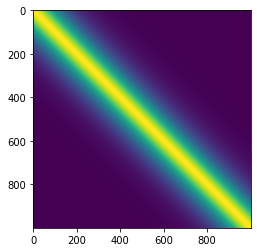

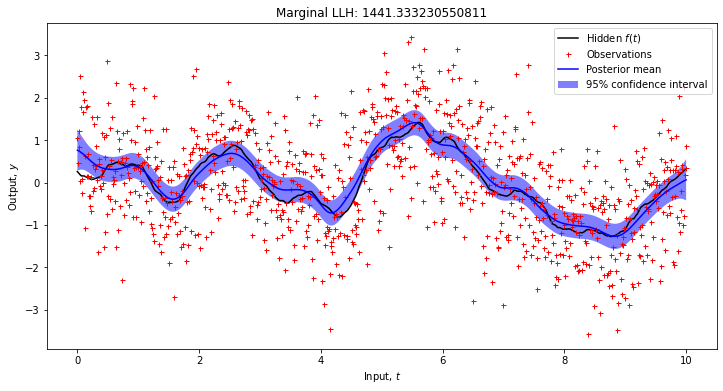

In [2]:
## Part 1: Simulate some data

# Observation time indices
t = np.linspace(0,10,n).reshape((n,1))

# Set up kernel (Matern nu=3/2)
tx,ty=np.meshgrid(t,t);
D = abs(tx-ty)
K = magnSigma2 * (1 + np.sqrt(3)*D/ell) * np.exp(-np.sqrt(3)*D/ell)
print("Heat map of Matern kernel")
plt.imshow(K)
# Draw a random sample from the GP prior
np.random.seed(43)
L = np.linalg.cholesky(K)
f = L.dot(np.random.randn(n))
y = f + np.sqrt(sigma2)*np.random.randn(n)

#print(np.random.randn(n))
## Part 2: Naive GP inference

# Start timing
start = time.process_time() 

# Solve the GP regression problem the naive way
alpha = np.linalg.solve(K+sigma2*np.eye(n), y)
L = np.linalg.cholesky(K+sigma2*np.eye(n))
v = np.linalg.solve(L, K)
Eft = K.dot(alpha) # Posterior mean
Varft = np.diag(K) - np.sum(v**2,axis=0) # Marginal variance

# Negative log marginal likelihood
# note: np.sum(np.log(np.diag(L))) is the same as (1/2) * np.sum(np.log(np.diag(K+sigma2*np.eye(n)))
negloglik = n/2*np.log(2*np.pi) + np.sum(np.log(np.diag(L))) + (1/2)* y.T @ (np.linalg.inv(K+sigma2*np.eye(n))) @ y #.5*y.T.dot(alpha)

# End timing (this should grow O(n^3))
end = time.process_time()
print("Naive GP inference took %.3f s." % (end - start)) 

# Plot GP
plot_gp(t, f, y, Eft, Varft, negloglik)

### Task 1.1: Evaluating the marginal likelihood
Fill in the missing part inside the Kalman filter that evaluates the negative log marginal likelihood during the forward sweep. Look for the line with `negloglik += ?`. This quantity has to do with the so called innovation mean `v` and variance `s`. If you feel confused, look at the material in the lecture slides, or the two papers mentioned as pre-reading.

State space inference took 0.156 s.


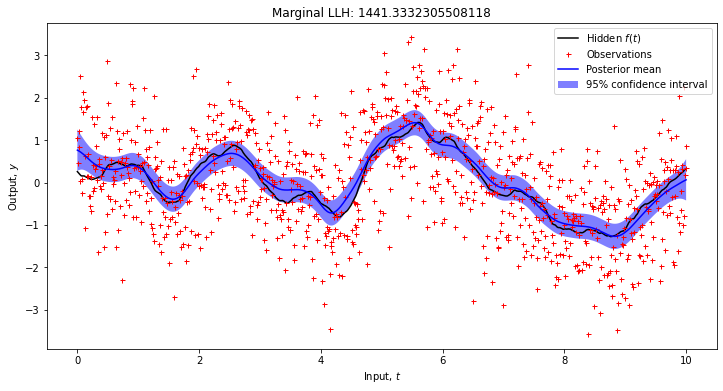

In [3]:
## State space GP inference

# Define continuous-time state space model (SDE):
lam = np.sqrt(3)/ell;
F = np.array([[0,1],[-lam**2,-2*lam]])
Pinf = np.array([[magnSigma2,0],[0,magnSigma2*lam**2]])
h = np.array([[1],[0]])

# Solve the SDE for discrete time steps:
# The resulting state transition matrix and process noise covariance
dt = t[1]-t[0]
A = linalg.expm(F*dt)
Q = Pinf - A.dot(Pinf).dot(A.T)

# State mean and covariance
M = np.zeros((F.shape[0],n))
P = np.zeros((F.shape[0],F.shape[0],n))
P[:,:,0] = Pinf
negloglik = 0

# Start timing
start = time.process_time()

# Kalman filter (forward pass)
for i in range(0,y.shape[0]):
    # Prediction step
    if i > 0:
        M[:,i] = A.dot(M[:,i-1])
        P[:,:,i] = A.dot(P[:,:,i-1]).dot(A.T) + Q
    
    # Update step
    v = y[i]-h.T.dot(M[:,i])
    s = h.T.dot(P[:,:,i]).dot(h) + sigma2
    k = P[:,:,i].dot(h) / s
    M[:,i] += k.dot(v)
    P[:,:,i] -= k.dot(h.T).dot(P[:,:,i])
    
    # Update log likelihood
    
    # == 
    # Task:
    # Change the line below to compute the marginal likelihood
    # ==
    # This one is better than solution
    v_scalar = v.item()
    s_scalar = s.item()
    negloglik +=  0.5 * np.log(np.abs(2*np.pi*s_scalar)) + 0.5 * v_scalar * (1/s_scalar) * v_scalar
    
    # Model solution
    #negloglik += (1/2) * (np.log(2 * np.pi * np.linalg.det(s))) + (1/2) * (v * s **(-1) * v)
           
# Rauch-Tung-Striebel smoother (backward pass)
for i in range(y.shape[0]-2,-1,-1):
    Pp = A.dot(P[:,:,i]).dot(A.T) + Q
    G = np.linalg.solve(Pp, (P[:,:,i].dot(A.T)).T).T
    M[:,i] += G.dot(M[:,i+1]-A.dot(M[:,i]))
    P[:,:,i] += G.dot(P[:,:,i+1]-Pp).dot(G.T)

    Eft[i] = h.T.dot(M[:,i])
    Varft[i] = h.T.dot(P[:,:,i]).dot(h)

# End timing (this should grow O(n))
end = time.process_time()
print("State space inference took %.3f s." % (end - start)) 
    
# Plot GP
plot_gp(t,f,y,Eft,Varft,negloglik)

### Task 1.2: State space GPs with the exponential kernel
Copy-over the code from above and modify the GP prior to use the exponential kernel instead of the Matern nu=3/2. This means that you need to define the covariance function and define the matrices `F = -1/ell`, `h = 1`, and `Pinf = magnSigma2`. This stochastic differential equation is known as the Ornstein-Uhlenbeck process (see, e.g., discussion in Rasmussen and Williams, 2006, Appendix B).
After changing the model, make sure that you still get the same solution both ways.

Heat map of exponential kernel
Naive GP inference took 7.312 s.


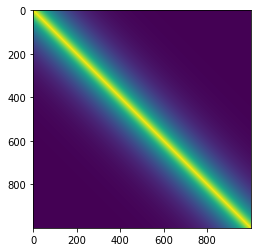

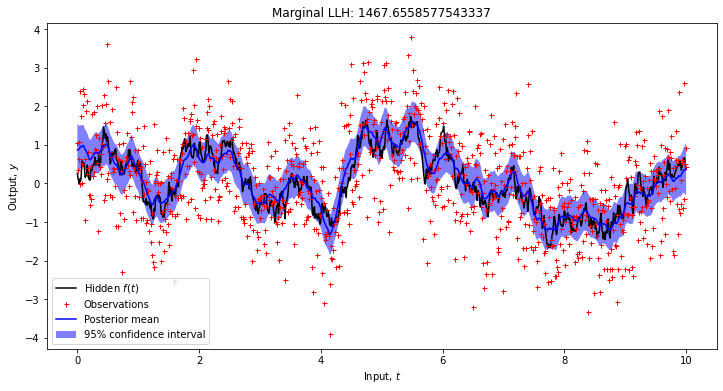

In [4]:
# ==
# Task 1.2
# Compute kernel matrix using the exponential kernel
# ==

lam = 1/ell
K = magnSigma2 * np.exp(-lam*D) # Code goes here
print("Heat map of exponential kernel")
plt.imshow(K)

# Draw a random sample from the GP prior
np.random.seed(43)
L = np.linalg.cholesky(K)
f = L.dot(np.random.randn(n))
y = f + np.sqrt(sigma2)*np.random.randn(n)

## Naive GP inference

# Start timing
start = time.process_time() 

# Solve the GP regression problem the naive way
alpha = np.linalg.solve(K+sigma2*np.eye(n), y)
L = np.linalg.cholesky(K+sigma2*np.eye(n))
v = np.linalg.solve(L, K)
Eft = K.dot(alpha) # Posterior mean
Varft = np.diag(K) - np.sum(v**2,axis=0) # Marginal variance

# Negative log marginal likelihood
negloglik = n/2*np.log(2*np.pi) + np.sum(np.log(np.diag(L))) + .5*y.T.dot(np.linalg.inv(K+sigma2*np.eye(n))).dot(y) #.5*y.T.dot(alpha)

# End timing (this should grow O(n^3))
end = time.process_time()
print("Naive GP inference took %.3f s." % (end - start)) 

# Plot GP
plot_gp(t, f, y, Eft, Varft, negloglik)

State space inference took 0.141 s.


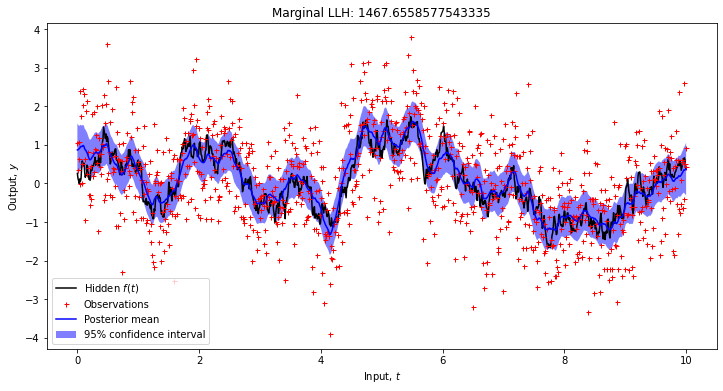

In [5]:
## State space GP inference

# ==
# Task 1.2
# Define SDE for a GP with exponential kernel
# ==

# This means that you need to define the covariance function and define the matrices 
# F = -1/ell, h = 1, and Pinf = magnSigma2

# Define continuous-time state space model (SDE):
# lam = 1/ell
F = np.array([[-lam]])
Pinf = magnSigma2
h = np.array([[1]])

# Solve the SDE for discrete time steps:
# The resulting state transition matrix and process noise covariance
dt = t[1]-t[0]
A = linalg.expm(F*dt)
Q = Pinf - A.dot(Pinf).dot(A.T)

# State mean and covariance
M = np.zeros((F.shape[0],n))
P = np.zeros((F.shape[0],F.shape[0],n))
P[:,:,0] = Pinf
negloglik = 0

# Start timing
start = time.process_time()

# Kalman filter (forward pass)
for i in range(0,y.shape[0]):
    # Prediction step
    if i > 0:
        M[:,i] = A.dot(M[:,i-1])
        P[:,:,i] = A.dot(P[:,:,i-1]).dot(A.T) + Q
    
    # Update step
    v = y[i]-h.T.dot(M[:,i])
    s = h.T.dot(P[:,:,i]).dot(h) + sigma2
    k = P[:,:,i].dot(h) / s
    M[:,i] += k.dot(v)
    P[:,:,i] -= k.dot(h.T).dot(P[:,:,i])
    
    # Update log likelihood
    
    # == 
    # Code to replace negloglik calculation here
    # ==
    v_scalar = v.item()
    s_scalar = s.item()
    negloglik += 0.5 * np.log(np.abs(2*np.pi*s_scalar)) + 0.5 * v_scalar * (1/s_scalar) * v_scalar
           
# Rauch-Tung-Striebel smoother (backward pass)
for i in range(y.shape[0]-2,-1,-1):
    Pp = A.dot(P[:,:,i]).dot(A.T) + Q
    G = np.linalg.solve(Pp, (P[:,:,i].dot(A.T)).T).T
    M[:,i] += G.dot(M[:,i+1]-A.dot(M[:,i]))
    P[:,:,i] += G.dot(P[:,:,i+1]-Pp).dot(G.T)

    Eft[i] = h.T.dot(M[:,i])
    Varft[i] = h.T.dot(P[:,:,i]).dot(h)

# End timing (this should grow O(n))
end = time.process_time()
print("State space inference took %.3f s." % (end - start)) 
    
# Plot GP
plot_gp(t,f,y,Eft,Varft,negloglik)

## Task 2: Activation functions (2 points)

- Use the code from previous week's exercises to code up a GP class, we need predictions for our BO loop, but to obtain them we also need to have a kernel function. 

- You can use any kernel you want but ensure that it passes the test with GPflow before you proceed.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import gpflow

In [7]:
# These all are equivalent

# kernelRBF = gpflow.kernels.RBF(lengthscales=0.2, variance=2)
# K1 = kernelRBF(x,x).numpy()

# dist_sq = np.sum((x[:,None] - x) ** 2, axis=2)
# K2 = 2 * np.exp(-dist_sq / (2 * (0.2**2))) 

# dist_sq = cdist(x, x, 'sqeuclidean')
# K3 = 2 * np.exp(-dist_sq / (2 * (0.2**2))) 

In [8]:
class GP():
    """
    Class for a GP model
    """
    def __init__(self, data, sigma2, length_scale=1, variance=1):
        """
        Initialize your GP class.
        Parameters
        ----------
        data : Tuple of regression data input and observation e.g. (x, y).
        sigma2 : Float of likelihood variance.
        length_scale: Float for kernel lengthscale.
        variance: Float for kernel variance.
        """
        self.data = data
        self.x = data[0]
        self.y = data[1]
        self.sigma2 = sigma2
        self.variance = variance
        self.length_scale = length_scale
        
    def kernel(self, x, y):
        """
        Return the kernel k(x, y).
        Parameters
        ----------
        x : ndarray of shape (n_samples_x, 1)
        Y : ndarray of shape (n_samples_y, 1)
        Returns
        -------
        K : ndarray of shape (n_samples_X, n_samples_Y)
            Kernel k(X, Y)
        """
        # MODEL SOLUTION
        dists = cdist(x/self.length_scale, y/self.length_scale, metric="sqeuclidean") 
        K = self.variance * np.exp(-0.5 * dists)
        #dist_sq = cdist(x, y, 'sqeuclidean')
        #K = self.variance * np.exp(-dist_sq / (2 * (self.length_scale**2))) 
        return K


    def predict_f(self, x_new):
        """
        Return the mean and marginal variance of GP model.
        Parameters
        ----------
        x_new : ndarray of shape (n_samples_x_new, 1)
        Returns
        -------
        m : ndarray of shape (n_samples_x_new, 1)
        v : ndarray of shape (n_samples_x_new, 1)
        """
        n = self.x.shape[0]
        K_f_f = self.kernel(self.x, self.x)
        K_fstar_f = self.kernel(x_new, self.x)
        K_fstar_fstar = self.kernel(x_new, x_new)
        # alpha = np.linalg.solve(K + self.sigma2 * np.eye(n), y)
        # L = np.linalg.cholesky(K + self.sigma2 * np.eye(n))
        # vv = np.linalg.solve(L, np.transpose(K_p))
        # post_mu = K_p @ alpha
        # post_var = np.diag(K_pp) - np.sum(vv** 2, axis=0)
        # post_var = post_var[:, None] 
        post_mu = K_fstar_f @ np.linalg.inv(K_f_f + self.sigma2 * np.eye(self.x.shape[0])) @ self.y
        post_cov = K_fstar_fstar - K_fstar_f @ np.linalg.inv(K_f_f + self.sigma2 * np.eye(self.x.shape[0])) @ K_fstar_f.T
        post_var = np.diag(post_cov)[:,None]
        return post_mu, post_var

In [9]:
#Let test your model against GPflow

x = np.linspace(0,10,10)[:,None]
y = np.sin(x) + np.exp(x*0.2)
x_new = np.linspace(0,10,5)[:,None]

#Uncomment once you have your class
gp = GP((x,y),sigma2=1.0)
m,v = gp.predict_f(x_new)

gpr_gpflow = gpflow.models.GPR((x, y), gpflow.kernels.RBF(lengthscales=1.0, variance=1.0))
m_flow, v_flow = gpr_gpflow.predict_f(x_new)

np.testing.assert_allclose(m_flow, m, atol=1e-5)
np.testing.assert_allclose(v_flow, v, atol=1e-5)

Great now we have a GP model lets code up some activation functions!
- I have added the UCB activaton function which you can read about [here](https://arxiv.org/abs/0912.3995). Its a pretty simple activation function but has some nice theoretical properties.

- The other formulas can be found on slide 27 (**Expected Improvement**) and slide 35 (**Probability of Improvement**) of the lecture notes.


In [10]:
from scipy.special import ndtr
from scipy.stats import norm

def PI(mean, std, max_val):
    PIvalue = ndtr((mean - max_val) / std)
    return PIvalue

def EI(mean, std, max_val):
    temp = (mean - max_val)/std
    EIvalue = (mean - max_val) * ndtr(temp) + std * norm.pdf(temp)
    return EIvalue

def UCB(mean, std, beta=1.0):
    UCBvalue = mean + beta * std
    return UCBvalue

- Ok now plot some activation functions on some initial data below. 
- Use the pre defined hyperparameters.
- Fit a GP model.
- Then plot the different activation functions evaluated on your initial dataset.
- Can you spot any differences?
- Play around with the beta variable in UCB. What effect does it have?
- Change N_data = 4 and 8 and plot the activation functions? 


[ 3.84611359  1.47863791 -0.15254479 -0.86305985 -1.25457587  1.83239766
 -0.49142204 -3.52257683]


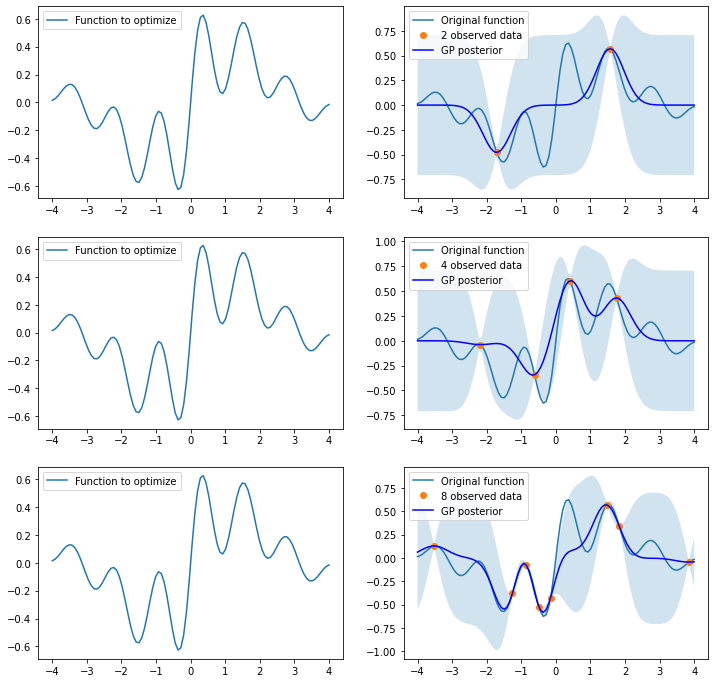

In [11]:
def multimodal_func_1(x):
    return 5 * (1.5*np.sin(x) + np.sin(5 * x)) * 0.1*np.exp(-np.abs(0.5*x))

# Create grid and sample some data from the function between [-4,4]
N = 100
X = np.linspace(-4,4,N)
np.random.seed(123)
N_data1 = 2
N_data2 = 4
N_data3 = 8

X_data1 = np.random.uniform(-4,4,N_data1)
Y_data1 = multimodal_func_1(X_data1)

X_data2 = np.random.uniform(-4,4,N_data2)
Y_data2 = multimodal_func_1(X_data2)

X_data3 = np.random.uniform(-4,4,N_data3)
print(X_data3)
Y_data3 = multimodal_func_1(X_data3)

# Get the GP posterior from that data sample
post_means1, post_vars1 = GP((X_data1[:,None], Y_data1[:,None]), 
                           sigma2=0.0001, length_scale=0.4, variance=0.5).predict_f(X[:,None])
post_means1, post_vars1 = post_means1.squeeze(), post_vars1.squeeze()
#print(X_data1[:,None].shape)
#print(Y_data1[:,None].shape)
#print(X[:,None].shape)
# Get the GP posterior from that data sample
post_means2, post_vars2 = GP((X_data2[:,None], Y_data2[:,None]), 
                           sigma2=0.0001, length_scale=0.4, variance=0.5).predict_f(X[:,None])
post_means2, post_vars2 = post_means2.squeeze(), post_vars2.squeeze()

# Get the GP posterior from that data sample
post_means3, post_vars3 = GP((X_data3[:,None], Y_data3[:,None]), 
                           sigma2=0.0001, length_scale=0.4, variance=0.5).predict_f(X[:,None])
post_means3, post_vars3 = post_means3.squeeze(), post_vars3.squeeze()

# Plotting
fig, ax = plt.subplots(3,2,figsize=(12,12))
ax[0][0].plot(X, multimodal_func_1(X))
ax[0][0].legend(["Function to optimize"])
ax[0][1].plot(X, multimodal_func_1(X))
ax[0][1].plot(X_data1, Y_data1, 'o')
ax[0][1].plot(X, post_means1, c='b')
ax[0][1].fill_between(X.squeeze(), post_means1 + np.sqrt(post_vars1), post_means1 - np.sqrt(post_vars1), alpha=0.2)
ax[0][1].legend(["Original function", "2 observed data", "GP posterior"])

ax[1][0].plot(X, multimodal_func_1(X))
ax[1][0].legend(["Function to optimize"])
ax[1][1].plot(X, multimodal_func_1(X))
ax[1][1].plot(X_data2, Y_data2, 'o')
ax[1][1].plot(X, post_means2, c='b')
ax[1][1].fill_between(X.squeeze(), post_means2 + np.sqrt(post_vars2), post_means2 - np.sqrt(post_vars2), alpha=0.2)
ax[1][1].legend(["Original function", "4 observed data", "GP posterior"])

ax[2][0].plot(X, multimodal_func_1(X))
ax[2][0].legend(["Function to optimize"])
ax[2][1].plot(X, multimodal_func_1(X))
ax[2][1].plot(X_data3, Y_data3, 'o')
ax[2][1].plot(X, post_means3, c='b')
ax[2][1].fill_between(X.squeeze(), post_means3 + np.sqrt(post_vars3), post_means3 - np.sqrt(post_vars3), alpha=0.2)
ax[2][1].legend(["Original function", "8 observed data", "GP posterior"])

Text(0.5, 1.0, 'UCB - N_data=8, beta=2')

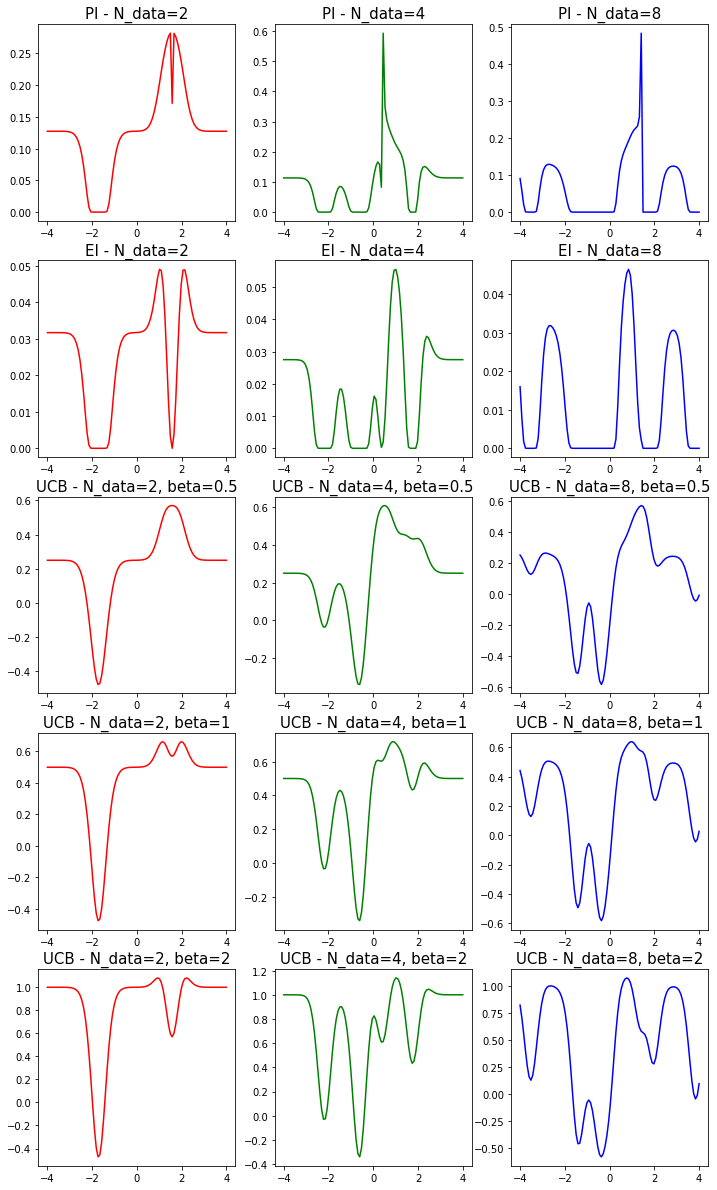

In [12]:
# TODO: Plot the activation functions

max_val1 = np.max(Y_data1)
max_val2 = np.max(Y_data2)
max_val3 = np.max(Y_data3)

PI_values1 = PI(post_means1, post_vars1, max_val1)
PI_values2 = PI(post_means2, post_vars2, max_val2)
PI_values3 = PI(post_means3, post_vars3, max_val3)

EI_values1 = EI(post_means1, post_vars1, max_val1)
EI_values2 = EI(post_means2, post_vars2, max_val2)
EI_values3 = EI(post_means3, post_vars3, max_val3)

UCB_values1 = UCB(post_means1, post_vars1, beta=0.5)
UCB_values2 = UCB(post_means2, post_vars2, beta=0.5)
UCB_values3 = UCB(post_means3, post_vars3, beta=0.5)

UCB_values4 = UCB(post_means1, post_vars1, beta=1)
UCB_values5 = UCB(post_means2, post_vars2, beta=1)
UCB_values6 = UCB(post_means3, post_vars3, beta=1)

UCB_values7 = UCB(post_means1, post_vars1, beta=2)
UCB_values8 = UCB(post_means2, post_vars2, beta=2)
UCB_values9 = UCB(post_means3, post_vars3, beta=2)
#print(PI_values)

fontsize=15
fig, ax = plt.subplots(5,3,figsize=(12,21))
ax[0][0].plot(X, PI_values1, color="r")
ax[0][1].plot(X, PI_values2, color="g")
ax[0][2].plot(X, PI_values3, color="b")
ax[0][0].set_title("PI - N_data=2", fontsize=fontsize)
ax[0][1].set_title("PI - N_data=4", fontsize=fontsize)
ax[0][2].set_title("PI - N_data=8", fontsize=fontsize)
#ax[0][0].fill_between(X.squeeze(), post_means1 + np.sqrt(post_vars1), post_means1 - np.sqrt(post_vars1), alpha=0.2)
#ax[0][1].fill_between(X.squeeze(), post_means2 + np.sqrt(post_vars2), post_means2 - np.sqrt(post_vars2), alpha=0.2)
#ax[0][2].fill_between(X.squeeze(), post_means3 + np.sqrt(post_vars3), post_means3 - np.sqrt(post_vars3), alpha=0.2)

ax[1][0].plot(X, EI_values1, color="r")
ax[1][1].plot(X, EI_values2, color="g")
ax[1][2].plot(X, EI_values3, color="b")
ax[1][0].set_title("EI - N_data=2", fontsize=fontsize)
ax[1][1].set_title("EI - N_data=4", fontsize=fontsize)
ax[1][2].set_title("EI - N_data=8", fontsize=fontsize)

ax[2][0].plot(X, UCB_values1, color="r")
ax[2][1].plot(X, UCB_values2, color="g")
ax[2][2].plot(X, UCB_values3, color="b")
ax[2][0].set_title("UCB - N_data=2, beta=0.5", fontsize=fontsize)
ax[2][1].set_title("UCB - N_data=4, beta=0.5", fontsize=fontsize)
ax[2][2].set_title("UCB - N_data=8, beta=0.5", fontsize=fontsize)

ax[3][0].plot(X, UCB_values4, color="r")
ax[3][1].plot(X, UCB_values5, color="g")
ax[3][2].plot(X, UCB_values6, color="b")
ax[3][0].set_title("UCB - N_data=2, beta=1", fontsize=fontsize)
ax[3][1].set_title("UCB - N_data=4, beta=1", fontsize=fontsize)
ax[3][2].set_title("UCB - N_data=8, beta=1", fontsize=fontsize)

ax[4][0].plot(X, UCB_values7, color="r")
ax[4][1].plot(X, UCB_values8, color="g")
ax[4][2].plot(X, UCB_values9, color="b")
ax[4][0].set_title("UCB - N_data=2, beta=2", fontsize=fontsize)
ax[4][1].set_title("UCB - N_data=4, beta=2", fontsize=fontsize)
ax[4][2].set_title("UCB - N_data=8, beta=2", fontsize=fontsize)


- Differences between the three activation functions

PI tries to maximize the probability that the value of the objective function at a new input point will exceed the current maximum value observed so far. PI is useful useful in scenarios where the objective function is expensive to evaluate, as it focuses on finding the best value of the objective function as quickly as possible.

EI tries to maximize the expected improvement in the objective function value at a new input point relative to the current maximum value observed so far. EI is useful in scenarios where the objective function is noisy, as it focuses on finding regions of the input space that are likely to have a large improvement over the current best value.

UCB balances the trade-off between exploration and exploitation by selecting input points that maximize a combination of the mean and the uncertainty of the objective function prediction. UCB is useful in scenarios where the objective function is smooth and continuous, as it focuses on exploring both known and unknown regions of the input space regulated by the beta parameter.

- Play around with the beta variable in UCB. What effect does it have?

Beta is a hyperparameter that controls the trade-off between exploration and exploitation. It determines the degree of uncertainty in the estimate of the objective function. 

Lower beta value corresponds to lower exploration and higher exploitation.
Higher beta value corresponds to higher exploration and lower exploitation.

- Change N_data = 4 and 8 and plot the activation functions? (already done above)

## Task 3: Bayesian optimization loop (1 point)

- Run your own Bayesian optimization loop on the gramacy lee function, fix the hyperparameters to something you think is sensible.
- Then run for each activation function and plot the regret (code below).

In [13]:
def gramacy_lee(x):
    """
    The Gramacy & Lee function, typically evaluated over :math:`[0.5, 2.5]`. See
    :cite:`gramacy2012cases` for details.
    :param x: Where to evaluate the function, with shape [..., 1].
    :return: The function values, with shape [..., 1].
    """
    return -(np.sin(10 * np.pi * x) / (2 * x) + (x - 1) ** 4)

In [14]:
x = np.linspace(0.5,2.5,100)[:,None]
y = gramacy_lee(x)

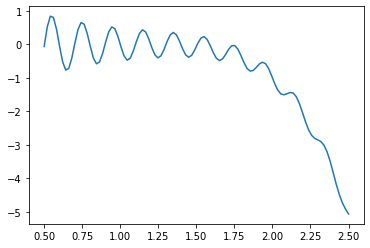

In [15]:
plt.plot(x, y)

In [16]:
from scipy.optimize import minimize

def bayes_optimization(activation_func, sigma2=0.0001, length_scale=0.1, variance=2,
                      N_obs_total=10):
    """A Bayesian optimization loop.
    activation_func -- The used activation function # PI, EI or UCB
    sigma2 -- The likelihood variance
    length_scale -- The RBF kernel length scale
    variance -- The RBF kernel variance
    N_obs_total -- How many Bayesian optimization steps to take?
    
    Returns:
    X_obs -- An array of length N_obs_total, containing the chosen X points in order
    Y_obs -- An array of length N_obs_total, containing the function values corresponding to X_obs
    """
    X_obs = np.array([2.0]) # Starting guess, this can be changed
    Y_obs = gramacy_lee(X_obs)
    
    for i in range(N_obs_total-1):
        ## Code here to figure out new_point
        
        post_means, post_vars = GP((X_obs[:,None], Y_obs[:,None]), 
                                    sigma2=sigma2, 
                                    length_scale=length_scale, 
                                    variance=variance).predict_f(x)
        
        post_means, post_stds = post_means.squeeze(), np.sqrt(post_vars.squeeze())
        # maximizing the acquisition function
        index_of_x_maximizing_acquisition_function = np.argmax(activation_func(post_means, post_stds, np.max(Y_obs)))
        new_point = x[index_of_x_maximizing_acquisition_function]
        X_obs = np.concatenate([X_obs, new_point])
        Y_obs = np.concatenate([Y_obs, gramacy_lee(new_point)])
    return X_obs, Y_obs

def plot_bo_results(X_obs, Y_obs, activation_func, sigma2=0.0001, length_scale=0.1, variance=2):
    fig, ax = plt.subplots(4,5, figsize=(20,16))
    for i in range(1,21):
        x_ = (i-1)%5
        y_ = (i-1)//5
        post_means, post_vars = GP((X_obs[:i,None], Y_obs[:i,None]), 
                               sigma2, length_scale, variance).predict_f(x)
        post_means, post_vars = post_means.squeeze(), post_vars.squeeze()

        ax[y_,x_].plot(X_obs[:i], Y_obs[:i], 'o')
        ax[y_,x_].plot(x, y)
        ax[y_,x_].plot(x,post_means)
        ax[y_,x_].fill_between(x.squeeze(), post_means + np.sqrt(post_vars), post_means - np.sqrt(post_vars), alpha=0.2)
        handle = ax[y_,x_].plot(x, activation_func(post_means, np.sqrt(post_vars), np.max(Y_obs[:i])))
    plt.legend(handle, ["Activation function"],loc=3)

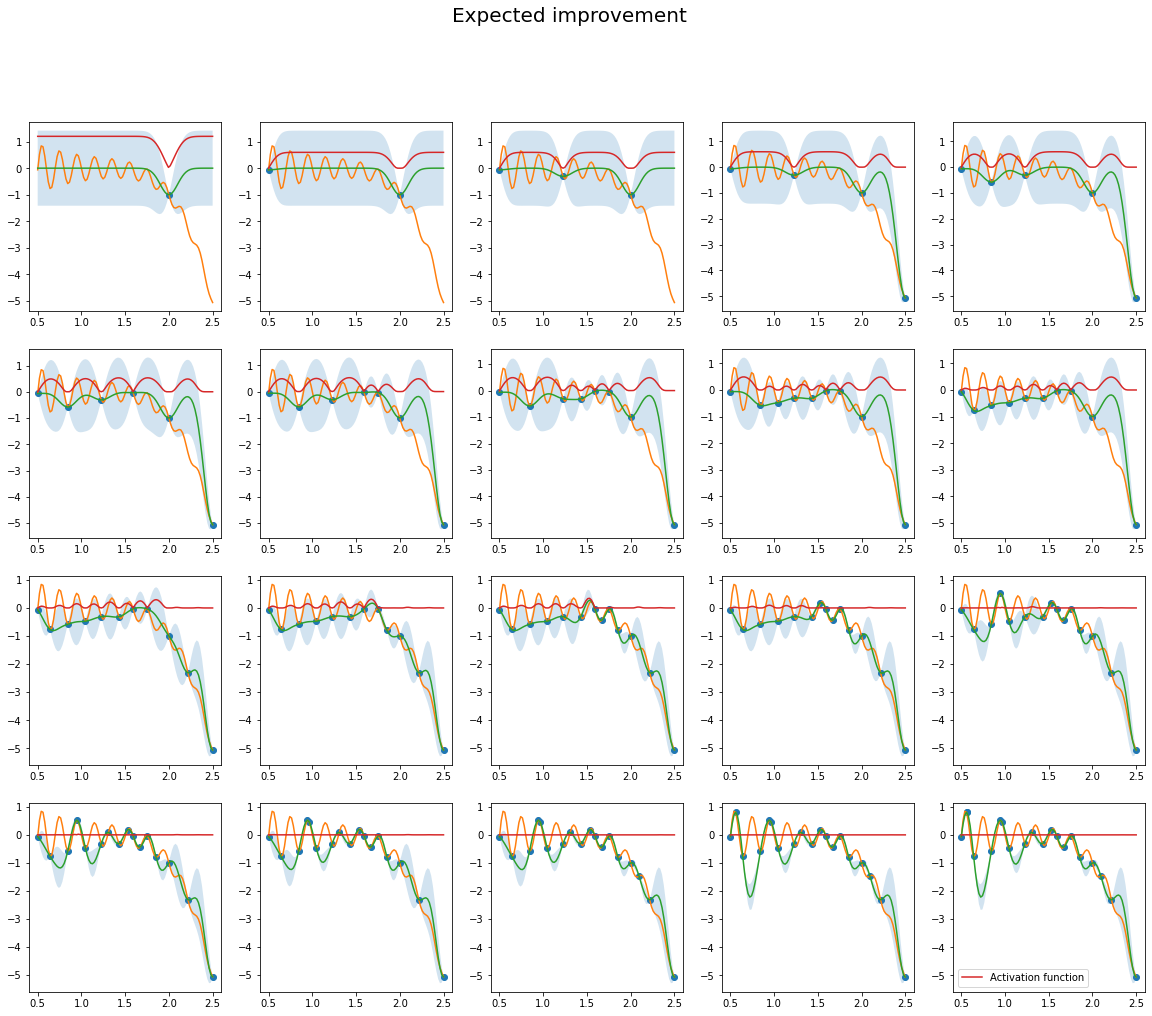

In [17]:
# Expected improvement
sigma2 = 0.0001
length_scale = 0.1
variance = 2
activation_func = EI
N_obs_total = 20
X_obs, Y_obs = bayes_optimization(activation_func, 
                                  sigma2=sigma2, 
                                  length_scale=length_scale, 
                                  variance=variance,
                                  N_obs_total=N_obs_total)
plot_bo_results(X_obs, Y_obs, activation_func, sigma2, length_scale, variance)
plt.suptitle("Expected improvement", fontsize=20)
plt.show()

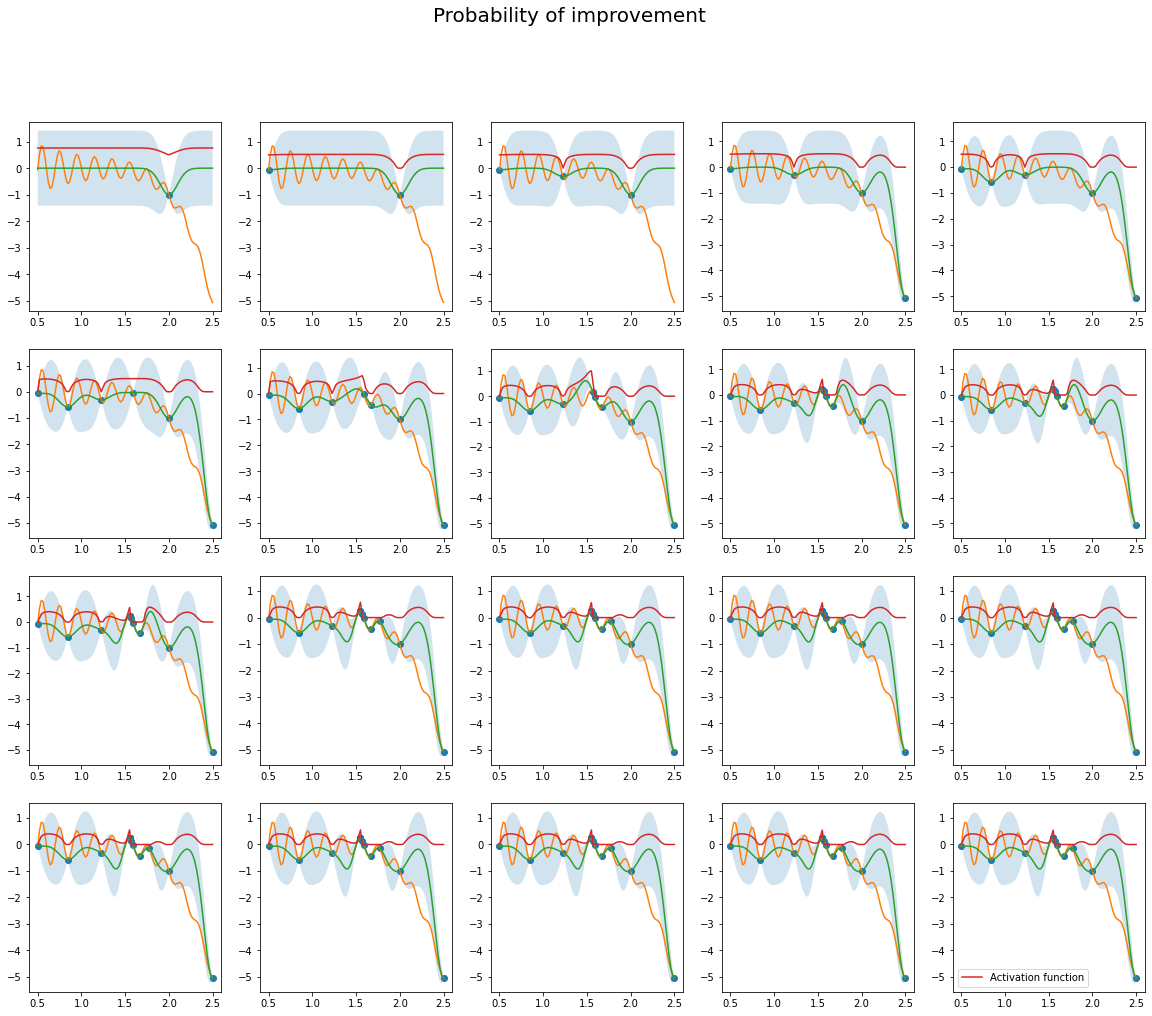

In [18]:
# Probability of improvement
sigma2 = 0.0001
length_scale = 0.1
variance = 2
activation_func = PI
N_obs_total = 20
X_obs, Y_obs = bayes_optimization(activation_func, 
                                  sigma2=sigma2, 
                                  length_scale=length_scale, 
                                  variance=variance,
                                  N_obs_total=N_obs_total)
plot_bo_results(X_obs, Y_obs, activation_func, sigma2, length_scale, variance)
plt.suptitle("Probability of improvement", fontsize=20)
plt.show()

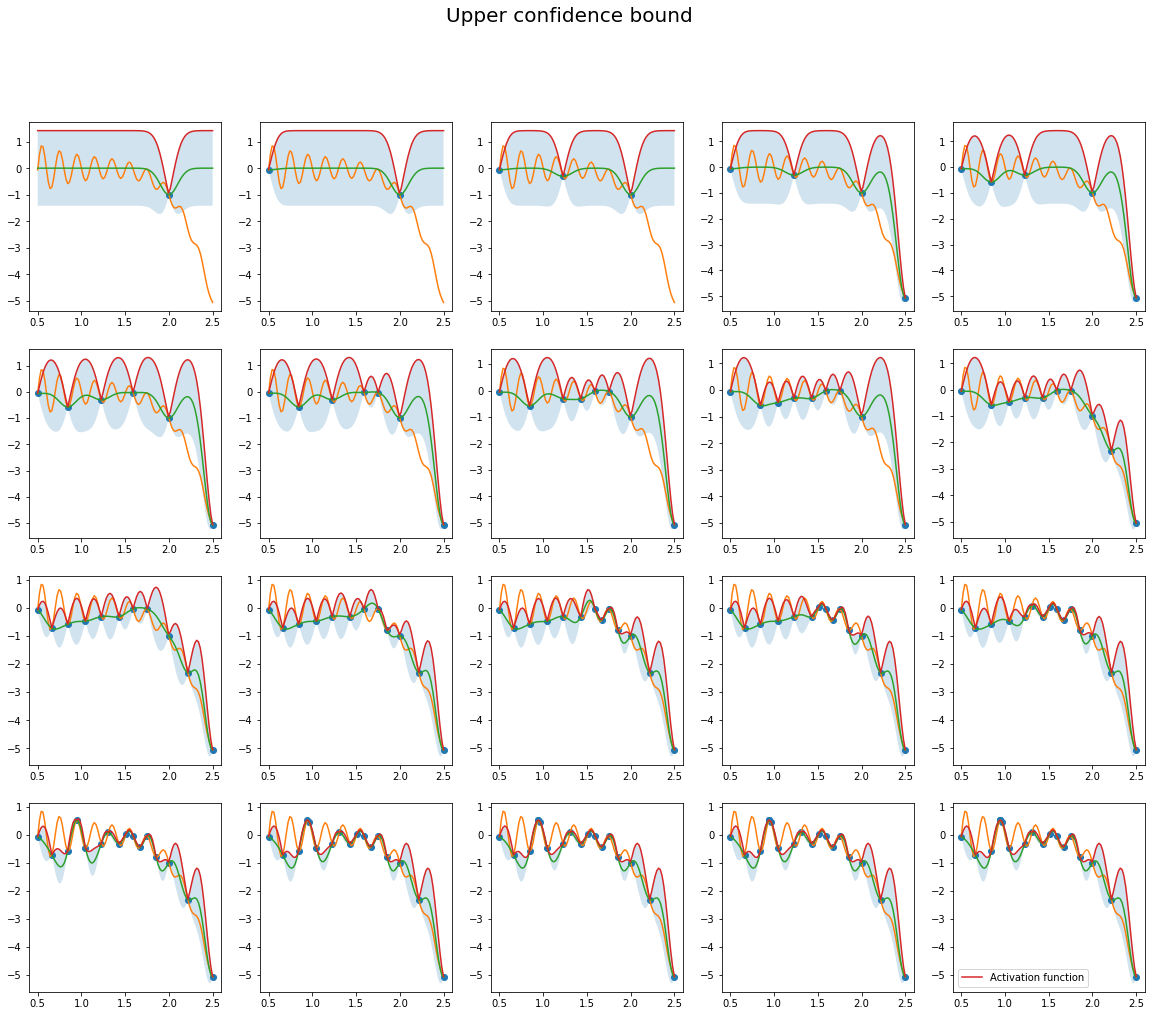

In [19]:
# UCB
sigma2 = 0.0001
length_scale = 0.1
variance = 2
activation_func = lambda mean, std, max_val: UCB(mean, std) # add the max_val as a dummy argument here
N_obs_total = 20
X_obs, Y_obs = bayes_optimization(activation_func, 
                                  sigma2=sigma2, 
                                  length_scale=length_scale, 
                                  variance=variance,
                                  N_obs_total=N_obs_total)
plot_bo_results(X_obs, Y_obs, activation_func, sigma2, length_scale, variance)
plt.suptitle("Upper confidence bound", fontsize=20)
plt.show()

Regret plots are common way to visualise and show how the BO loop performs against some maximum/minimum.

- Use the code below to show 3 regret plots for the three activation function strategies from above. You can choose the number of iterations but we suggest perhaps only a few initial points.

In [20]:
gramacy_lee_max = 0.548562

In [21]:
def format_point_markers(
    num_pts,
    num_init,
    idx_best=None,
    mask_fail=None,
    m_init="x",
    m_add="circle",
    c_pass="green",
    c_fail="red",
    c_best="darkmagenta",
):
    """
    Prepares point marker styles according to some BO factors
    :param num_pts: total number of BO points
    :param num_init: initial number of BO points
    :param idx_best: index of the best BO point
    :param mask_fail: Boolean vector, True if the corresponding observation violates the constraint(s)
    :param m_init: marker for the initial BO points
    :param m_add: marker for the other BO points
    :param c_pass: color for the regular BO points
    :param c_fail: color for the failed BO points
    :param c_best: color for the best BO points
    :return: 2 string vectors col_pts, mark_pts containing marker styles and colors
    """

    col_pts = np.repeat(c_pass, num_pts).astype("<U15")
    mark_pts = np.repeat(m_init, num_pts).astype("<U15")
    mark_pts[num_init:] = m_add
    if mask_fail is not None:
        col_pts[mask_fail] = c_fail
    if idx_best is not None:
        col_pts[idx_best] = c_best

    return col_pts, mark_pts

def plot_regret(
    obs_values,
    ax,
    show_obs=True,
    num_init=None,
    mask_fail=None,
    idx_best=None,
    m_init="x",
    m_add="o",
    c_pass="tab:green",
    c_fail="tab:red",
    c_best="tab:purple",
):
    """
    Draws the simple regret
    :param obs_values:
    :param ax:
    :param show_obs:
    :param num_init:
    :param mask_fail:
    :param idx_best:
    :param m_init:
    :param m_add:
    :param c_pass:
    :param c_fail:
    :param c_best:
    :return:
    """

    col_pts, mark_pts = format_point_markers(
        obs_values.shape[0], num_init, idx_best, mask_fail, m_init, m_add, c_pass, c_fail, c_best
    )

    safe_obs_values = obs_values.copy()
    if mask_fail is not None:
        safe_obs_values[mask_fail] = np.max(obs_values)

    ax.plot(np.maximum.accumulate(safe_obs_values), color="tab:orange")

    if show_obs:
        for i in range(obs_values.shape[0]):
            ax.scatter(i, obs_values[i], c=col_pts[i], marker=mark_pts[i])

    ax.axvline(x=num_init - 0.5, color="tab:blue")

Text(0.5, 1.0, 'UCB regret plot')

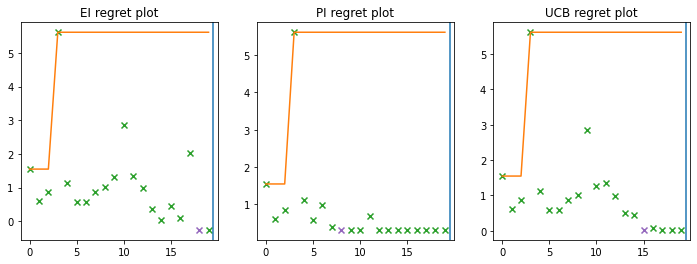

In [22]:
sigma2 = 0.0001
length_scale = 0.1
variance = 2

_, ax = plt.subplots(1, 3, figsize=(12,4))

act_funcs = [EI, PI, lambda mean, std, max_val: UCB(mean,std)]
for i in range(3):
    activation_func = act_funcs[i]
    N_obs_total = 20
    X_obs, Y_obs = bayes_optimization(activation_func, 
                                      sigma2=sigma2, 
                                      length_scale=length_scale, 
                                      variance=variance,
                                      N_obs_total=N_obs_total)
    suboptimality = gramacy_lee_max - Y_obs
    plot_regret(
        suboptimality, ax[i], num_init=len(X_obs), idx_best=np.argmax(Y_obs)
    )

ax[0].set_title("EI regret plot")
ax[1].set_title("PI regret plot")
ax[2].set_title("UCB regret plot")